# Fine-tuned models benchmark - Domain shift?

When we benchmarked models on the LIMIT-small dataset we observed, that the results of the SoTA models was realy poor. In the following we want to find out, that may the low quality performance was caused by a domain shift (i.e. the tested models weren't be trained to similar tasks).

In order to achieve that, we fine-tuned previously a derived model from [modernbert-embed-large](https://huggingface.co/lightonai/modernbert-embed-large) by extending it a projection matrix, to get arbitrary dimensional embeddings, on the LIMIT dataset.

**This isn't finished yet! The correct parameters must be choosen for InfoNCE cached loss-based training.**

The fine-tuned models architecture is the following with variable output dimension:

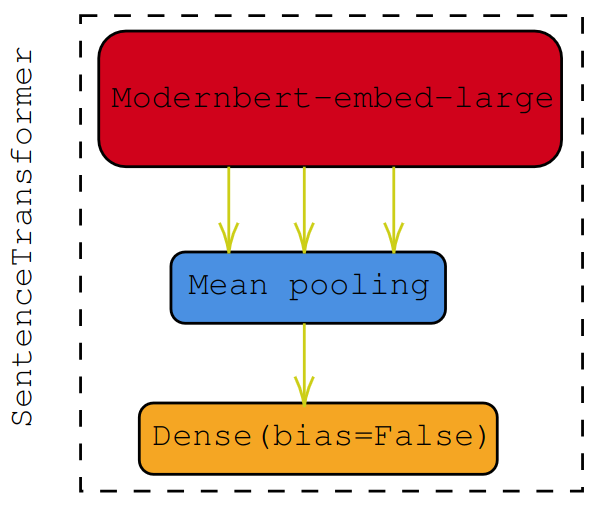

The extended model was fine-tuned on both train and test splits of the LIMIT dataset by varying output dimension of the `Dense` layer. These models can be accessed at the variations of the [modernbert-large-finetuned-embeddings](...) model.

Our hypothesis is the following:

- if there is a domain shift, then the fine-tuned models will achieve higher performence by evaluating them on the test set
- otherwise, we will not observe significant progress in case of the training set fine-tuned model, when we benchmark them on the test set of LIMIT

## Embed dataset

In the following we embed the LIMIT dataset with all of the fine-tuned models, both for on train and test sets.

In [1]:
from datasets import load_dataset

dataset_name = "orionweller/LIMIT"

qrels = load_dataset(dataset_name, "default", split="test").to_pandas()
corpus = load_dataset(dataset_name, "corpus", split="all").to_pandas()
queries = load_dataset(dataset_name, "queries", split="all").to_pandas()

README.md: 0.00B [00:00, ?B/s]

qrels.jsonl: 0.00B [00:00, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

corpus.jsonl:   0%|          | 0.00/32.5M [00:00<?, ?B/s]

Generating corpus split:   0%|          | 0/50000 [00:00<?, ? examples/s]

queries.jsonl: 0.00B [00:00, ?B/s]

Generating queries split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [2]:
# For compatibility we run the model instances on a single T4 GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda"

In [3]:
dimension = 1024
# split = "test"
split="test-cached-loss"
version = 2
# base_directory = "/kaggle/input/modernbert-large-finetuned/transformers"
base_directory = "/kaggle/input/modernbert-embed-large-finetuned/transformers"
model_variation = f"{dimension}d-limit-{split}/{version}"

In [4]:
import torch
import torch.nn as nn
import json
import os

class TokenProjection(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.linear = nn.Linear(in_features, out_features, bias=bias)
    
    def forward(self, features):
        # features["token_embeddings"]: (batch, seq_len, in_features)
        token_emb = features["token_embeddings"]
        projected = self.linear(token_emb)
        features["token_embeddings"] = projected
        return features
    
    def get_config_dict(self):
        return {
            'in_features': self.in_features,
            'out_features': self.out_features,
            'bias': self.bias
        }
    
    def save(self, output_path):
        os.makedirs(output_path, exist_ok=True)
        with open(os.path.join(output_path, 'config.json'), 'w') as f:
            json.dump(self.get_config_dict(), f)
        
        torch.save(self.state_dict(), os.path.join(output_path, 'token_projection_model.bin'))
    
    @staticmethod
    def load(input_path):
        with open(os.path.join(input_path, 'config.json'), 'r') as f:
            config = json.load(f)
        
        model = TokenProjection(**config)
        model.load_state_dict(
            torch.load(
                os.path.join(input_path, 'token_projection_model.bin'), 
                map_location='cpu'
            )
        )
        return model

In [5]:
model_variation

'1024d-limit-test-cached-loss/2'

In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer(
    f"{base_directory}/{model_variation}",
    local_files_only=True,
    device=device
)

2026-01-12 18:00:55.461209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768240855.655904      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768240855.710113      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768240856.157441      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768240856.157478      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768240856.157480      55 computation_placer.cc:177] computation placer alr

In [7]:
import pickle
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

def embed_dataset(
    corpus: pd.DataFrame,
    queries: pd.DataFrame,
    model: SentenceTransformer,
    save_path: str,
    batch_size: int = 512
):
    sentences = [text for text in corpus["text"]]
    embeddings = model.encode(sentences, batch_size=batch_size, show_progress_bar=True, normalize_embeddings=True)
    doc_embs = {_id: emb for _id, emb in zip(corpus["_id"], embeddings)}
    
    sentences = [text for text in queries["text"]]
    embeddings = model.encode(sentences, batch_size=batch_size, show_progress_bar=True, normalize_embeddings=True)
    query_embs = {_id: emb for _id, emb in zip(queries["_id"], embeddings)}
    
    with open(save_path, "wb") as file:
        pickle.dump([doc_embs, query_embs], file)    

In [8]:
variation = model_variation.split("/")[0]
embed_dataset(
    corpus=corpus,
    queries=queries,
    model=model,
    save_path=f"modernbert-large-finetuned-{variation}.pkl"
)

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

W0112 18:02:18.594000 55 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

## Benchmark models based on their generate embeddings

In [1]:
from datasets import load_dataset

dataset_name = "orionweller/LIMIT"

qrels = load_dataset(dataset_name, "default", split="test").to_pandas()
corpus = load_dataset(dataset_name, "corpus", split="all").to_pandas()
queries = load_dataset(dataset_name, "queries", split="all").to_pandas()

README.md: 0.00B [00:00, ?B/s]

qrels.jsonl: 0.00B [00:00, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

corpus.jsonl:   0%|          | 0.00/32.5M [00:00<?, ?B/s]

Generating corpus split:   0%|          | 0/50000 [00:00<?, ? examples/s]

queries.jsonl: 0.00B [00:00, ?B/s]

Generating queries split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [2]:
import numpy as np
import pickle

def load_embeded_dataset(
    embbedings_path: str
) -> tuple[dict[str, np.ndarray], dict[str, np.ndarray]]:
    with open(embbedings_path, "rb") as file:
        doc_embs, query_embs = pickle.load(file)

    return doc_embs, query_embs

In [3]:
import pandas as pd

def recall(
    recall_at: int, 
    corpus: pd.DataFrame,
    queries: pd.DataFrame,
    qrels: pd.DataFrame,
    doc_embs: dict[str, np.ndarray],
    query_embs: dict[str, np.ndarray]
) -> float:
        queries["index"] = range(len(queries))
        corpus["index"] = range(len(corpus))
        
        # align embedding matrices with corpus/query order (for safety)
        D = np.stack([doc_embs[_id] for _id in corpus["_id"]]).T
        Q = np.stack([query_embs[qid] for qid in queries["_id"]]).T
        D = D.astype(np.float64, copy=False)
        Q = Q.astype(np.float64, copy=False)
            
        A = Q.T @ D
        
        # uses quickselect under the hood
        # we need to select indexes of the top-k largest values -> -A
        retrieved_docs = np.argpartition(-A, kth=recall_at-1, axis=1)[:, :recall_at]
        retrieved_docs = [
            set(corpus["_id"].iloc[docs].to_list())
            for docs in retrieved_docs
        ]
    
        qrels_map = (
            qrels.groupby("query-id")["corpus-id"]
            .apply(set)
            .to_dict()
        )
        
        relevant_docs = [
            qrels_map[qid]
            for qid in queries["_id"]
        ]
    
        total = 0
        for ret, rel in zip(retrieved_docs, relevant_docs):
            total += len(ret & rel) / len(rel)
            
        return total / len(relevant_docs)

In [4]:
dims = [32, 64, 128, 256, 384, 512, 768, 1024]
def get_embeddings_path(dim: int, split: str = "train") -> str:
    # return f"/kaggle/input/modernbert-large-finetuned-embeddings/modernbert-large-finetuned-{dim}d-limit-{split}.pkl"
    return f"/kaggle/input/modernbert-embed-large-finetuned-embeddings/modernbert-large-finetuned-{dim}d-limit-{split}.pkl"

In [5]:
for d in [64]:
    doc_embs, query_embs = load_embeded_dataset(
        embbedings_path=get_embeddings_path(dim=d, split="test-cached-loss")
    )
    print(f"dim: {d}")
    for r in [2, 10, 100]:
        rec = recall(
            recall_at=r, 
            corpus=corpus,
            queries=queries,
            qrels=qrels,
            doc_embs=doc_embs,
            query_embs=query_embs
        )
        print(f"recall@{r} = {rec}")

dim: 64
recall@2 = 0.3075
recall@10 = 0.3855
recall@100 = 0.4945


In [6]:
for d in [64]:
    doc_embs, query_embs = load_embeded_dataset(
        embbedings_path=get_embeddings_path(dim=d, split="test")
    )
    print(f"dim: {d}")
    for r in [2, 10, 100]:
        rec = recall(
            recall_at=r, 
            corpus=corpus,
            queries=queries,
            qrels=qrels,
            doc_embs=doc_embs,
            query_embs=query_embs
        )
        print(f"recall@{r} = {rec}")

dim: 64
recall@2 = 0.1695
recall@10 = 0.3315
recall@100 = 0.634


In [5]:
for d in [64]:
    doc_embs, query_embs = load_embeded_dataset(
        embbedings_path=get_embeddings_path(dim=d, split="test-cached-loss-2")
    )
    print(f"dim: {d}")
    for r in [2, 10, 100]:
        rec = recall(
            recall_at=r, 
            corpus=corpus,
            queries=queries,
            qrels=qrels,
            doc_embs=doc_embs,
            query_embs=query_embs
        )
        print(f"recall@{r} = {rec}")

dim: 64
recall@2 = 0.3235
recall@10 = 0.395
recall@100 = 0.5005


In [12]:
for d in [64]:
    doc_embs, query_embs = load_embeded_dataset(
        embbedings_path=get_embeddings_path(dim=d, split="test-cached-loss-3")
    )
    print(f"dim: {d}")
    for r in [2, 10, 100]:
        rec = recall(
            recall_at=r, 
            corpus=corpus,
            queries=queries,
            qrels=qrels,
            doc_embs=doc_embs,
            query_embs=query_embs
        )
        print(f"recall@{r} = {rec}")

for d in [32, 128]:
    doc_embs, query_embs = load_embeded_dataset(
        embbedings_path=get_embeddings_path(dim=d, split="test-cached-loss")
    )
    print(f"dim: {d}")
    for r in [2, 10, 100]:
        rec = recall(
            recall_at=r, 
            corpus=corpus,
            queries=queries,
            qrels=qrels,
            doc_embs=doc_embs,
            query_embs=query_embs
        )
        print(f"recall@{r} = {rec}")


dim: 64
recall@2 = 0.3465
recall@10 = 0.4245
recall@100 = 0.526
dim: 32
recall@2 = 0.3795
recall@10 = 0.4425
recall@100 = 0.5245
dim: 128
recall@2 = 0.2825
recall@10 = 0.3735
recall@100 = 0.5225


In [6]:
for d in [1024]:
    doc_embs, query_embs = load_embeded_dataset(
        embbedings_path=get_embeddings_path(dim=d, split="test-cached-loss")
    )
    print(f"dim: {d}")
    for r in [2, 10, 100]:
        rec = recall(
            recall_at=r, 
            corpus=corpus,
            queries=queries,
            qrels=qrels,
            doc_embs=doc_embs,
            query_embs=query_embs
        )
        print(f"recall@{r} = {rec}")

for d in [1024]:
    doc_embs, query_embs = load_embeded_dataset(
        embbedings_path=get_embeddings_path(dim=d, split="train-cached-loss")
    )
    print(f"dim: {d}")
    for r in [2, 10, 100]:
        rec = recall(
            recall_at=r, 
            corpus=corpus,
            queries=queries,
            qrels=qrels,
            doc_embs=doc_embs,
            query_embs=query_embs
        )
        print(f"recall@{r} = {rec}")

for d in [1024]:
    doc_embs, query_embs = load_embeded_dataset(
        embbedings_path=get_embeddings_path(dim=d, split="test-cached-loss-2")
    )
    print(f"dim: {d}")
    for r in [2, 10, 100]:
        rec = recall(
            recall_at=r, 
            corpus=corpus,
            queries=queries,
            qrels=qrels,
            doc_embs=doc_embs,
            query_embs=query_embs
        )
        print(f"recall@{r} = {rec}")

dim: 1024
recall@2 = 0.331
recall@10 = 0.4525
recall@100 = 0.6165
dim: 1024
recall@2 = 0.0255
recall@10 = 0.0565
recall@100 = 0.167
dim: 1024
recall@2 = 0.0155
recall@10 = 0.0335
recall@100 = 0.103


dim 32, recall@2 0.5285
dim 64, recall@2 0.3355
dim 128, recall@2 0.299
dim 256, recall@2 0.4585
dim 384, recall@2 0.572
dim 512, recall@2 0.636
dim 768, recall@2 0.701
dim 1024, recall@2 0.7405


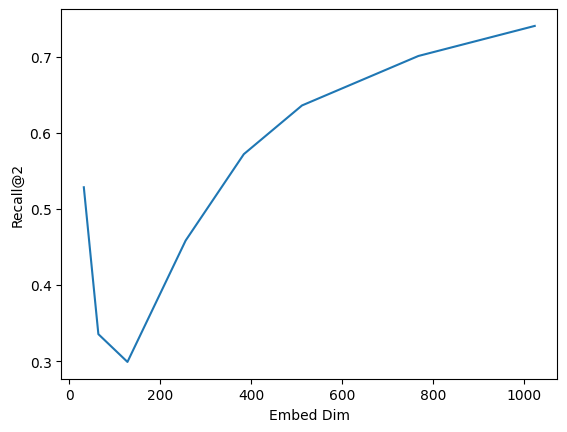

dim 32, recall@2 0.713
dim 64, recall@2 0.5375
dim 128, recall@2 0.558
dim 256, recall@2 0.736
dim 384, recall@2 0.8325
dim 512, recall@2 0.8855
dim 768, recall@2 0.91
dim 1024, recall@2 0.921


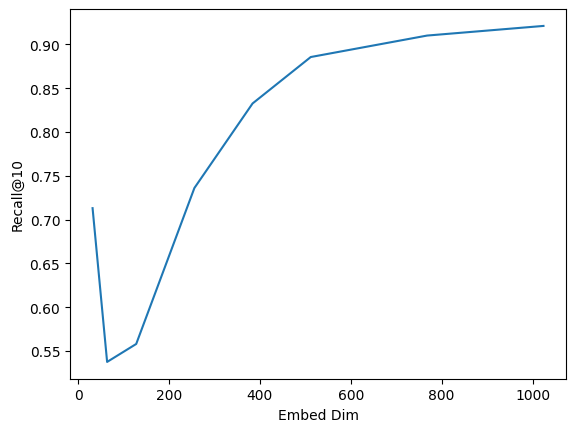

dim 32, recall@2 0.8775
dim 64, recall@2 0.8165
dim 128, recall@2 0.8835
dim 256, recall@2 0.9695
dim 384, recall@2 0.9815
dim 512, recall@2 0.9905
dim 768, recall@2 0.9905
dim 1024, recall@2 0.9955


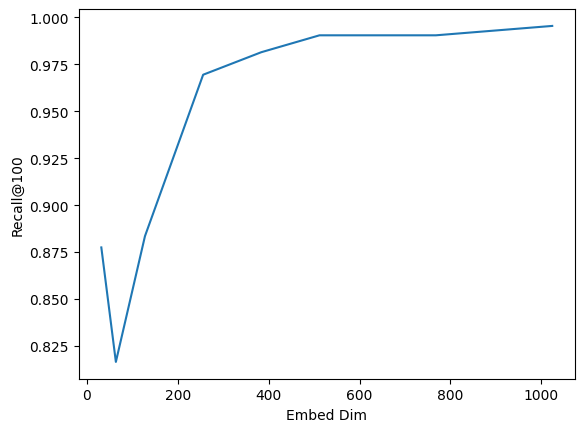

In [10]:
# TODO: put the plots to the same diagrams, arranged horizontally
import matplotlib.pyplot as plt

for r in [2, 10, 100]:
    plt.xlabel("Embed Dim")
    plt.ylabel(f"Recall@{r}")
    recalls = []
    for dim in dims:        
        doc_embs, query_embs = load_embeded_dataset(
            embbedings_path=get_embeddings_path(dim, split="test")
        )
        
        recalls.append(
            recall(
                recall_at=r, 
                corpus=corpus,
                queries=queries,
                qrels=qrels,
                doc_embs=doc_embs,
                query_embs=query_embs
            )            
        )    
    for d, r in zip(dims, recalls):
        print(f"dim {d}, recall@2 {r}")
    plt.plot(dims, recalls)
    plt.show()
    plt.close()